# REAL OPTIONS VALUATION
## Least-squares Monte Carlo method

In 2001, Longstaff and Schwartz proposed a simple yet powerful numerical procedure to compute option prices using a regression framework, which they called LSM (Least Squares Monte Carlo). This method can be applied to value American-style options when the binomial method renders itself unusable.

The Longstaff and Schwartz method aproximates the conditional expected option value by:
* simulating lots of paths
* carrying out a regression analysis of the value of continuing on the set of basis functions of relevant variables each time an early exercise decision has to be made

[Here](https://github.com/bdmitry09/Real-Options/blob/master/ROV-2/LSMonteCarlo.ipynb) you can find replication of the first example in "Valuing American Options by Simulation: A Simple Least-Squares Approach" by Longstaff and Schwartz.

In this study, our basic setup is the same as in our previous example. We will value the abandonment option of the soybean processing facility. Here we will additionaly assume that the risk-neutral drift is the same as the true drift.


In [1]:
import os
from time import sleep
from warnings import filterwarnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm import tqdm
import statsmodels.formula.api as smf

import xlwings as xw

from rpy2.robjects import pandas2ri

filterwarnings('ignore')
pandas2ri.activate()


In [2]:
figure = {'figsize': (16, 6),
          'facecolor': '#f9f9f9',
          'subplot.wspace': 0.1,
          'dpi': 120}

colors = ["#ab5787",
          "#51b2e5",
          "#703c5c",
          "#168dd9",
          "#d190b6",
          "#00609f",
          "#d365ba",
          "#154866",
          "#666666",
          "#c4c4c4"]

axes = {'grid': True,
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False,
        'grid.axis': 'y',
        'facecolor': '#f9f9f9',
        'edgecolor': '#f9f9f9',
        'autolimit_mode': 'round_numbers',
        'xmargin': 0,
        'prop_cycle': cycler('color', colors)}

grid = {'color': '#979797', 'linewidth': 0.2}

tick = {'color': '#979797', 'major.size': 0, 'minor.size': 0}

plt.rc('figure', **figure)
plt.rc('axes', **axes)
plt.rc('grid', **grid)
plt.rc(('xtick', 'ytick'), **tick)


In [3]:
link = 'https://www.indexmundi.com/commodities/?commodity=soybeans&months=360'

df = pd.DataFrame()

if not os.path.exists('soybean_prices.csv'):
    df = (pd.read_html(link,
                       attrs={'class': 'tblData'},
                       header=0, parse_dates=['Month'])[0]
          .drop('Change', axis=1)
          .to_csv('soybean_prices.csv'))

df = (pd.read_csv('soybean_prices.csv', parse_dates=['Month'])
      .drop(columns={'Unnamed: 0'})
      .rename(str.lower, axis='columns')
      .rename(columns={'price': 'soybeans'})
      .set_index('month'))


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -i df -o coefs
require('yuima')
set.seed(0)

df <- data.frame(df)

gbm <- setModel(drift=0, diffusion="sigma*x")

model <- setYuima(data=setData(df, delta=1/12), model=gbm)

fit <- qmle(model,
            start=list(sigma=0.1),
            lower=list(sigma=0.01),
            upper=list(sigma=1))

result <- summary(fit)@coef


coefs <- data.frame(rownames(result), result)


In [6]:
(coefs.rename(columns={'rownames.result.': 'Coefficients'})
 .set_index('Coefficients'))


,Estimate,Std..Error
Coefficients,,
sigma,0.173449,0.006451


In [7]:
%%R
set.seed(seed=0)

coef = fit@coef

simulate_gbm <- function (time=9) {
    samp <- setSampling(Initial=1, delta=1, n=time)
    
    X <- simulate(gbm, sampling=samp, true.parameter=coef,
                  xinit=df[length(df[,1]),])
  
    return(as.list(data.frame(get.zoo.data(X))))}

In [8]:
n_sims = 1000

wb = xw.Book('ROV_model_2.xlsx')


sht_inputs = wb.sheets['Inputs']
dr, t = sht_inputs.range('assum').value
t = int(t)
sht_inputs.range('date').value = df.index[-1]
sht_inputs.range('prices').value = df.iloc[-1, :].values

soybean_prices = np.zeros((n_sims, t-1))
S = np.zeros((n_sims, t))

sht = wb.sheets['Calculations_s']
K = np.array(sht.range('strike').value)

temp = sht.range('sim_inp').value

for i in tqdm(range(n_sims)):
    X = %R -i t simulate_gbm(time=t-1)
    soybean_prices[i] = np.array(X)[:, 1:]

for i in tqdm(range(n_sims)):
    sim_out = soybean_prices[i]
    sht.range('sim_inp').value = sim_out
    S[i] = sht.range('sim_out').value

sht.range('sim_inp').value = temp


100%|██████████| 1000/1000 [00:47<00:00, 19.37it/s]


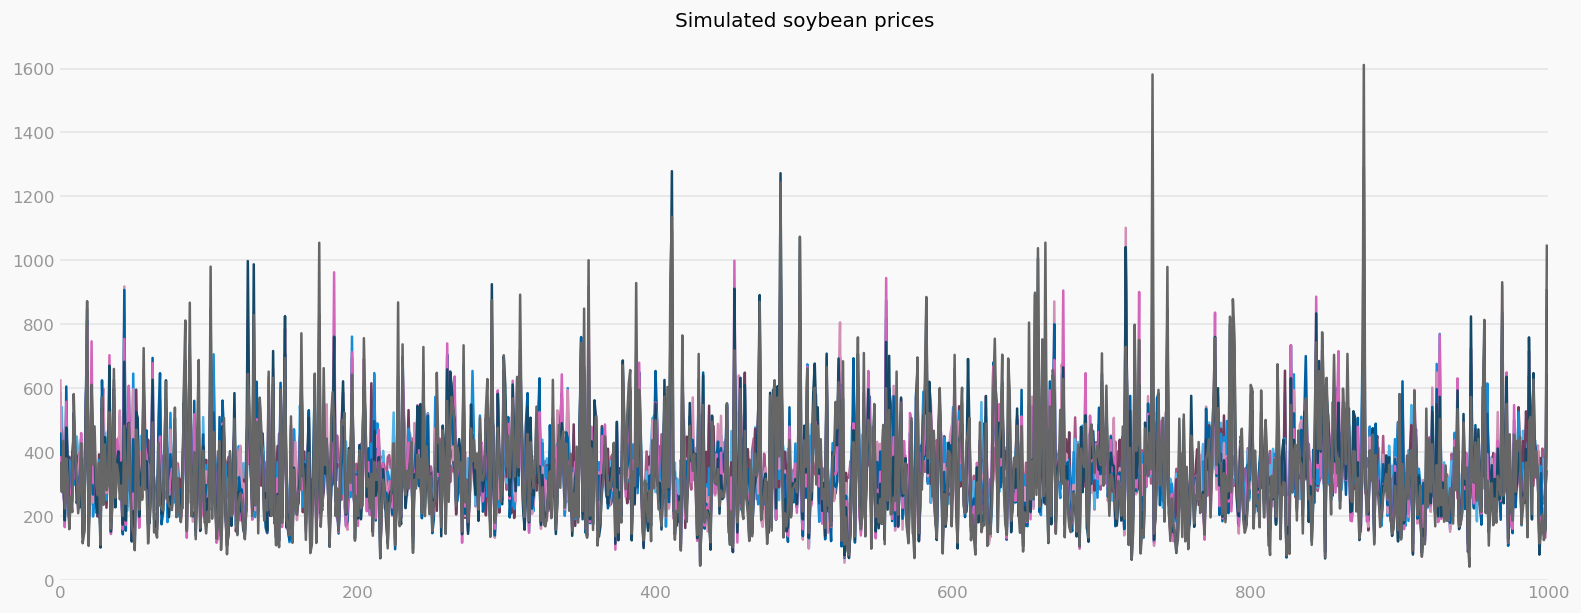

In [9]:
plt.plot(soybean_prices)
plt.ylim((0,1700))
plt.title('Simulated soybean prices');

In [10]:
CF = np.zeros((n_sims, t))
V = np.maximum(K - S, 0)
dif_f = 1 / (1 + dr)
CF[:,-1] = V[:, -1]
for tp in range(t-2, 0, -1):
    ind = V[:, tp] > 0
    X = soybean_prices[ind, tp]
    Y = CF[ind, tp + 1] * dif_f
    dat = {'Y': Y, 'X':X}
    reg = smf.ols('Y ~ X + X**2', data=dat).fit()
    C_pred = reg.fittedvalues
    CF[ind, tp] = np.where(V[ind, tp] > C_pred, V[ind, tp], 0)
    CF[CF[:, tp] > 0, tp + 1 :] = 0
disc_rate_mat = np.cumprod(np.full((1, t-1), dif_f))
CF[:, 0] = np.sum(CF[:, 1 : ] * disc_rate_mat, axis=1)
print("Real option value is {}\n".format(np.sum(CF[:, 0]) / n_sims))


Real option value is 18981.07606105853



Oh, boy. The option value is a magnitude higher than our previous estimate with the binomial model! Let's look at the cash flows matrix.

In [11]:
pd.DataFrame(CF).rename(columns={0:'PV0'}).head(10)

,PV0,1,2,3,4,5,6,7,8,9
0,51718.849191,54304.791651,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,4087.830796,0.000000,0.000000,0.0,0.0,0.0,5478.084229,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,56703.614505,59538.795230,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
5,609.132641,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,944.964653
6,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
7,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
8,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9,47527.361648,0.000000,52398.916217,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


We can see that for some paths, our option value is very high. This is because some cash flows are negative and the value of abandonment becomes very large. To get a better grasp on what’s really is going on here, let’s repeat the simulation, but now with cash flows forced to be nonnegative.

In [12]:
sht2 = wb.sheets['Calculations_s_2']
temp = sht2.range('sim_inp_2').value
S2 = np.zeros((n_sims, t))

for i in tqdm(range(n_sims)):
    sim_out = soybean_prices[i]
    sht2.range('sim_inp_2').value = sim_out
    S2[i] = sht2.range('sim_out_2').value

sht2.range('sim_inp_2').value = temp

100%|██████████| 1000/1000 [00:39<00:00, 25.52it/s]


In [13]:
CF2 = np.zeros((n_sims, t))
V2 = np.maximum(K - S2, 0)

CF2[:,-1] = V2[:, -1]
for tp in range(t-2, 0, -1):
    ind = V2[:, tp] > 0
    X = soybean_prices[ind, tp]
    Y = CF2[ind, tp + 1] * dif_f
    dat = {'Y': Y, 'X':X}
    reg = smf.ols('Y ~ X + X**2', data=dat).fit()
    C_pred = reg.fittedvalues
    CF2[ind, tp] = np.where(V2[ind, tp] > C_pred, V2[ind, tp], 0)
    CF2[CF2[:, tp] > 0, tp + 1 :] = 0

CF2[:, 0] = np.sum(CF2[:, 1 : ] * disc_rate_mat, axis=1)
print("Real option value is {}\n".format(np.sum(CF2[:, 0]) / n_sims))


Real option value is 3571.9989819735056



Now the option value is much closer to our previous estimate.